In [1]:
from src.pipelines.ingestion_pipeline import run_ingestion
from src.pipelines.preprocessing_pipeline import run_preprocessing
from src.pipelines.feature_pipeline import run_feature_engineering
from src.pipelines.model_pipeline import run_model_pipeline
from src.evaluation.notebook_validation import run_notebook_validation


d:\JAN\Program Files\Conda\envs\mastercard\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# 1. Ingest raw data
raw_df = run_ingestion(data_dir='../data', output_path='../data/raw_data.parquet')
print(f"Ingested {len(raw_df)} rows of raw data.")


Ingested 500000 rows of raw data.


In [3]:

processed_df = run_preprocessing(
    raw_data_path='../data/raw_data.parquet',
    output_path='../data/processed_data.parquet'
)
print(f"Preprocessed {len(raw_df)} rows of raw data.")

Preprocessed 500000 rows of raw data.


In [4]:
processed_df.head()

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,location,payment_method,...,distance_km,speed_kmph,amount/avg_amount,amount/sum_monthly_installments,amount/sum_monthly_expenses,country_u=t,country_m=t,countries_same,within_10pct,within_5pct
197951,TX197951,2022-01-08 16:48:00,U00001,M0245,32.24,online,EUR,Android,"{'lat': 54.710715, 'long': 15.368695}",mobile_payment,...,1994.074291,295.418413,0.163298,0.067491,0.132577,False,False,0,0.0,0.0
187979,TX187979,2022-01-12 16:23:00,U00001,M0332,4.29,in-store,EUR,Android,"{'lat': 58.897717, 'long': 30.25543}",debit_card,...,1016.169374,10.631611,0.23366,0.008981,0.017641,False,False,0,0.0,0.0
137034,TX137034,2022-01-18 10:40:00,U00001,M0331,67.0,in-store,EUR,iOS,"{'lat': 42.684202, 'long': 3.843828}",debit_card,...,2556.977104,18.491301,0.540715,0.140258,0.275516,False,False,0,0.0,0.0
401318,TX401318,2022-07-18 08:05:00,U00001,M0971,3.59,in-store,EUR,Web,"{'lat': 44.296089, 'long': 15.749937}",mobile_payment,...,976.612531,0.224952,3.663265,0.007515,0.014763,False,False,0,0.0,0.0
95555,TX095555,2022-08-09 12:30:00,U00001,M0598,22.94,online,EUR,iOS,"{'lat': 46.209657, 'long': 28.773734}",credit_card,...,1039.774561,1.952922,1.082586,0.048023,0.094333,False,False,0,0.0,0.0


In [5]:
print(list(processed_df.columns.values))

['transaction_id', 'timestamp', 'user_id', 'merchant_id', 'amount', 'channel', 'currency', 'device', 'location', 'payment_method', 'is_international', 'session_length_seconds', 'is_first_time_merchant', 'is_fraud', 'category', 'country_merchant', 'trust_score', 'number_of_alerts_last_6_months', 'avg_transaction_amount', 'account_age_months', 'has_fraud_history', 'age', 'sex', 'education', 'primary_source_of_income', 'sum_of_monthly_installments', 'sum_of_monthly_expenses', 'country_users', 'signup_date', 'risk_score', 'transaction_country', 'is_country_nan', 'country_merchant_distance_centroid', 'country_user_distance_centroid', 'country_merchant_distance_centroid_w', 'country_user_distance_centroid_w', 'Month_Year_EOM', 'Date', 'Year', 'hour', 'part_of_day', 'time_diff', 'time_diff_hours', 'latitude', 'longitude', 'lat_prev', 'lon_prev', 'time_prev', 'distance_km', 'speed_kmph', 'amount/avg_amount', 'amount/sum_monthly_installments', 'amount/sum_monthly_expenses', 'country_u=t', 'coun

In [6]:
prepare_kwargs = dict(
    to_drop=['transaction_id', 'user_id', 'currency', 'location'],
    to_think_but_drop=['signup_date','Month_Year_EOM','Date','Year','time_diff','time_prev',
                       'latitude','longitude','lat_prev','lon_prev'],
    to_categorize=['channel','device','payment_method','category','country_merchant','sex',
                   'education','primary_source_of_income','country_users','part_of_day','transaction_country'],
    cutoff="2023-07-01",
    target="is_fraud",
)

X_train, y_train, X_test, y_test = run_feature_engineering(
    processed_data_path="../data/processed_data.parquet",
    X_train_path="../data/X_train.parquet",
    X_test_path ="../data/X_test.parquet",
    y_train_path="../data/y_train.parquet",
    y_test_path ="../data/y_test.parquet",
    **prepare_kwargs
)

In [7]:

results = run_model_pipeline(
    X_train_path="../data/X_train.parquet",
    y_train_path="../data/y_train.parquet",
    X_test_path="../data/X_test.parquet",
    y_test_path="../data/y_test.parquet",
    model_output_path="../models/xgb_model.joblib",
    oversample=True,                    # RandomOverSampler
    xgb_params={                        # override defaults if needed
        "n_estimators": 1250,
        "learning_rate": 0.05,
        "max_depth": 5,
        "subsample": 0.5,
        "colsample_bytree": 0.8,
        "reg_alpha": 1,
        "reg_lambda": 1,
        "eval_metric": "auc",
        "random_state": 42,
    },
)

print(f"AUC train: {results['auc_train']:.4f}")
print(f"AUC test : {results['auc_test']:.4f}")


d:\JAN\Program Files\Conda\envs\mastercard\lib\site-packages\xgboost\core.py:158: UserWarning: [22:32:27] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AUC train: 0.8477
AUC test : 0.5631


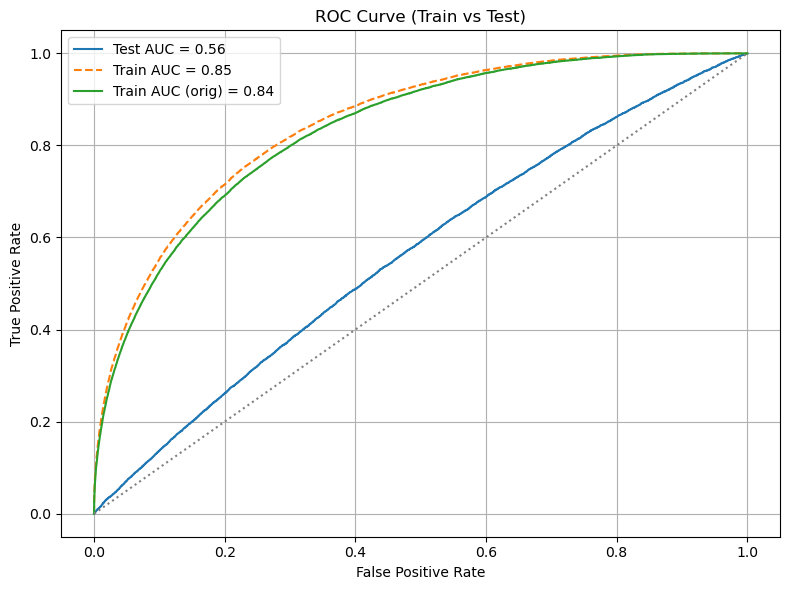

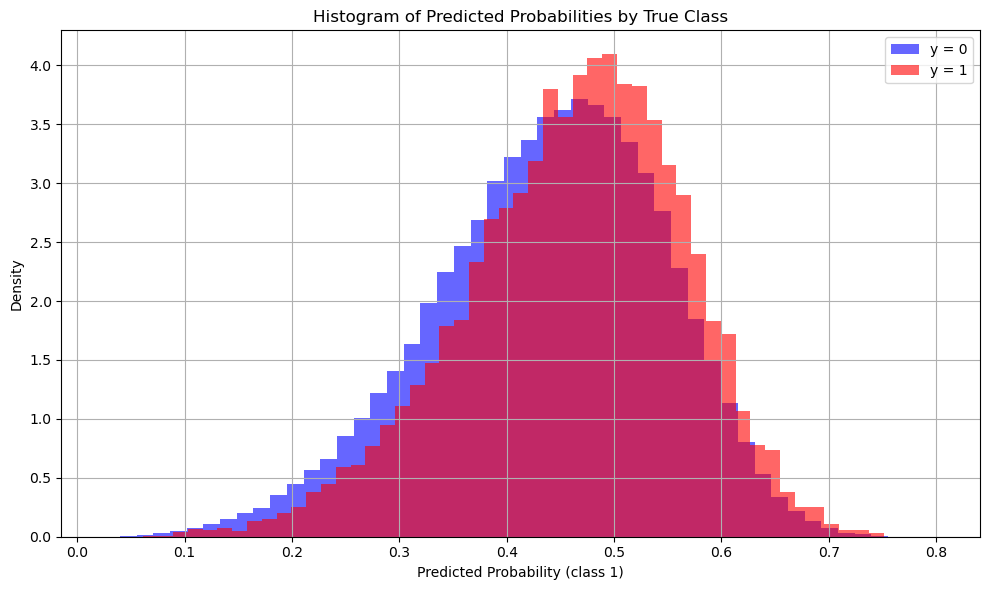

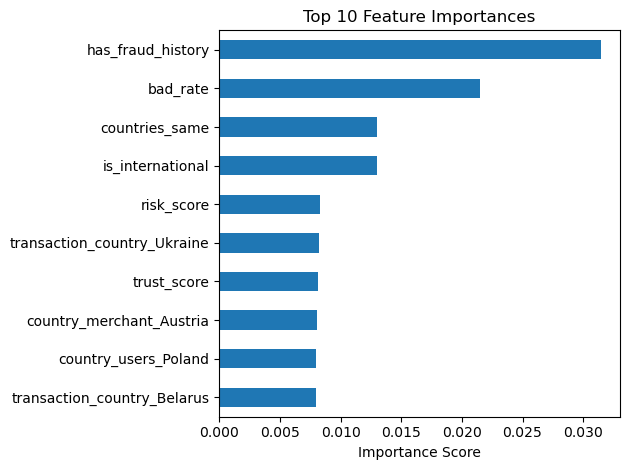

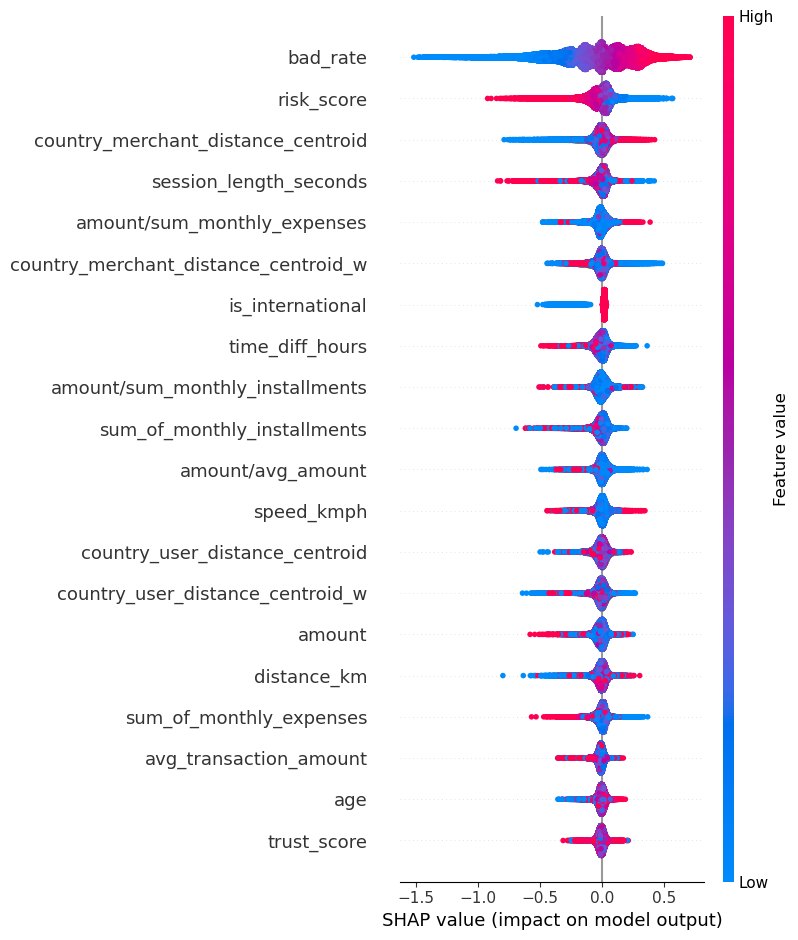

Top SHAP features: ['bad_rate', 'risk_score', 'country_merchant_distance_centroid']


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [8]:
run_notebook_validation(
    model=results["model"],
    X_train=results["X_train"],
    y_train=results["y_train"],
    X_train_oversampled=results["X_train_oversampled"],
    y_train_oversampled=results["y_train_oversampled"],
    X_test=results["X_test"],
    y_test=results["y_test"],
    top_pdp=3,
)